# <ins>Project 4 - Twitter Sentiment<ins>

## Business Understanding
I have been tasked by our companies stake holders to create a model that can classify tweets as positive as a first step towards helping our marketing department see the effects of their marketing strategies. The scope of this project is that first step

## Data Understanding
Data is taken from data.world. According to their website "Contributors evaluated tweets about multiple brands and products. The crowd was asked if the tweet expressed positive, negative, or no emotion towards a brand and/or product. If some emotion was expressed they were also asked to say which brand or product was the target of that emotion. Added: August 30, 2013 by Kent Cavender-Bares | Data Rows: 9093"
In other words, this data was manually classified as either Positive, Neutral, or Negative manually and now can be used to train a model to determine if a tweet can be classified as positive.

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import regexp_tokenize, RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, precision_score, confusion_matrix, ConfusionMatrixDisplay
import re
from collections import Counter

In [22]:
corpus = pd.read_csv("data/judge-1377884607_tweet_product_company.csv", 
                     encoding='latin1')

In [23]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [24]:
#dropping the lone null value in tweet_text
corpus.dropna(subset=['tweet_text'], inplace=True)

In [25]:
X = corpus['tweet_text']
y = corpus['is_there_an_emotion_directed_at_a_brand_or_product']

In [26]:
y.value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

We have a heavy imbalance toward no emotions which we will want to account for by undersampling no emotion toward brand or product and combining it with negative emotion.

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                   random_state=42,
                                                   test_size=0.25)

In [28]:
X_train

8605    Perfect attention to detail RT @mention Google...
1303    my iphone was stolen and I got it back !!!!!! ...
8759    fuck I love Austin. Just left the Youtube Goog...
5021    Spotted something rare a few minutes ago...a p...
3210    @mention fyi  RT @mention I'll be at the Austi...
                              ...                        
5735    RT @mention For those #notatSXSW (or at #SXSW)...
5192    RT @mention &quot;the future of local is conte...
5391    RT @mention Android may be gaining market shar...
861     .@mention Love it. @mention @mention #sxsw: &q...
7271    Anyone know status of iPad 2s in Austin pop-up...
Name: tweet_text, Length: 6819, dtype: object

In [29]:
y_train.value_counts()

No emotion toward brand or product    4068
Positive emotion                      2215
Negative emotion                       419
I can't tell                           117
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [30]:
#Map y_train values
y_train_tertiary = y_train.map(lambda x: 
    1 if x == "Positive emotion" 
    else 0 if x == "Negative emotion" 
    else -1  # Neutral tweets get -1
)

#Convert y_train into NumPy array for undersampling
X_train_array = np.array(X_train).reshape(-1, 1)  # Reshape for undersampling

#Undersample ONLY where y_train == -1 (neutral) to exactly 1,796
rus = RandomUnderSampler(sampling_strategy={-1: 1796}, random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_array, y_train_tertiary)

# Convert back to Series
y_train_resampled = pd.Series(y_train_resampled, name="y_train_resampled")
X_train_resampled = pd.Series(X_train_resampled.flatten(), name="X_train_resampled")
# Show class distribution after undersampling
print(y_train_resampled.value_counts())
print(X_train_resampled.value_counts())

 1    2215
-1    1796
 0     419
Name: y_train_resampled, dtype: int64
RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #sxsw                      4
Win free ipad 2 from webdoc.com #sxsw RT                                                                                            2
I just noticed DST is coming this weekend. How many iPhone users will be an hour late at SXSW come Sunday morning? #SXSW #iPhone    2
RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #SXSW                      2
Oh. My. God. The #SXSW app for iPad is pure, unadulterated awesome. It's easier to browse events on iPad than on the website!!!     2
                                                                                                                                   ..
#tech Before It Even Begins, #Apple Wins #SXSW: Over the past week, there's been a major dilemma in... {link} #technology    

In [31]:
print(X_train_resampled.shape, y_train_resampled.shape)

(4430,) (4430,)


In [32]:
X_train_resampled

0       #sxsw #enchantment: @mention &quot;Bright spot...
1       RT @mention Apple sets up temporary Austin sto...
2       I am neither at #SXSW nor buying an iPad 2 tod...
3       This is SO awesome. RT @mention Headed to #Aus...
4       @mention #webmobile talking about #mVideo. Tal...
                              ...                        
4425    Google to Launch Major New Social Network Call...
4426    Oooh. Want. RT @mention #Recap From recycled s...
4427       Before it even begins, Apple wins #SXSW {link}
4428    RT @mention &quot;the future of local is conte...
4429    .@mention Love it. @mention @mention #sxsw: &q...
Name: X_train_resampled, Length: 4430, dtype: object

In [33]:
y_train_resampled = y_train_resampled.map(lambda x: 1 if x == 1 else 0)
y_train_resampled.value_counts()

1    2215
0    2215
Name: y_train_resampled, dtype: int64

Now that we have more balanced data we're going to create some functions to make document cleaning easier for our data and prepare it for raw tweet data as well

In [34]:
sw = stopwords.words('english')

In [35]:
def get_wordnet_pos(treebank_tag):
    """
    Translate nltk POS to wordnet tags
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [36]:
def doc_preparer (doc, stop_words=sw):
    """
    a document from our corpus
    returns a document string with words that have been:
    lemmatized,
    parsed for stopwords,
    made lowercase,
    and stripped of punctuation and numbers.
    """
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:'[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
#    print(doc)
    doc = pos_tag(doc)
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer()
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [37]:
# Using our functions clean our data and tokenize
token_docs= [doc_preparer(doc, sw) for doc in X_train_resampled]

In [38]:
#Secondary train-test split to build best model
X_t ,X_val, y_t, y_val = train_test_split(token_docs, y_train_resampled, 
                                          test_size=0.25, random_state =42)

In [39]:
# Vectorizing our raw tokens using TF-IDF to assign them nominal values

tfidf = TfidfVectorizer(max_features=2000)
X_t_vec = tfidf.fit_transform(X_t)
X_val_vec = tfidf.transform(X_val)
X_t_vec = pd.DataFrame.sparse.from_spmatrix(X_t_vec)
X_t_vec.columns = sorted(tfidf.vocabulary_)
X_t_vec.set_index(y_t.index, inplace=True)

In [40]:
X_t_vec

,aapl,able,abt,acc,access,accessibility,accessory,accord,account,aclu,...,young,yourmom,youtube,yr,yrs,yup,zappos,zazzle,zazzlesxsw,zlf
3861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2882,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
910,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3092,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
# We then transform the validation set. 
X_val_vec = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(tfidf.vocabulary_)
X_val_vec.set_index(y_val.index, inplace = True)

### Data Modeling
Our data is now clean, and vectorized we can start with a simple Decision Tree to establish a baseline fit before looking at further modeling

In [42]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_t_vec, y_t)

DecisionTreeClassifier()

In [43]:
y_hat = dt_model.predict(X_val_vec)

Model Accuracy: 0.6074007220216606

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.63      0.63       586
           1       0.58      0.59      0.58       522

    accuracy                           0.61      1108
   macro avg       0.61      0.61      0.61      1108
weighted avg       0.61      0.61      0.61      1108



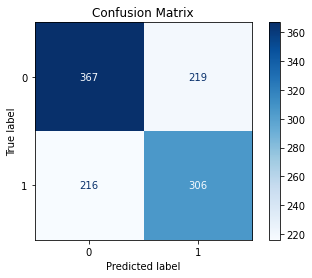

In [44]:
# Print accuracy score
print("Model Accuracy:", accuracy_score(y_val, y_hat))

# Print classification report
print("\nClassification Report:\n", classification_report(y_val, y_hat))

# Confusion Matrix
cm = confusion_matrix(y_val, y_hat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_model.classes_)
disp.plot(cmap='Blues')

# Show the plot
plt.title("Confusion Matrix")
plt.show()

In [45]:
mnb = MultinomialNB()

mnb.fit(X_t_vec, y_t)

MultinomialNB()

In [46]:
mnb_y_hat = mnb.predict(X_val_vec)

Model Accuracy: 0.6606498194945848

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.61      0.65       586
           1       0.62      0.72      0.67       522

    accuracy                           0.66      1108
   macro avg       0.67      0.66      0.66      1108
weighted avg       0.67      0.66      0.66      1108



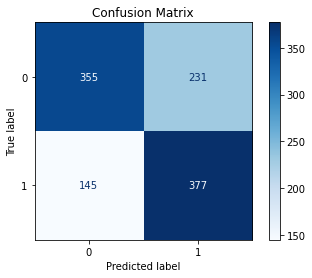

In [47]:
# Print accuracy score
print("Model Accuracy:", accuracy_score(y_val, mnb_y_hat))

# Print classification report
print("\nClassification Report:\n", classification_report(y_val, mnb_y_hat))

# Confusion Matrix
cm = confusion_matrix(y_val, mnb_y_hat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_model.classes_)
disp.plot(cmap='Blues')

# Show the plot
plt.title("Confusion Matrix")
plt.show()

## Evaluation
Our Multinomial Naive Bayes model is able to accurately predict if a tweet is positive 66% of the time, more importantly it has 62% precision. This is a good 4% better than our initial baseline Decision Tree Model. 

We care most about precision because tweets that are classified as positive but are actually negative are more hurtful to our marketing than losing a little bit of insight from classifying a tweet as negative that is actually negative. 

## Recommendation
Use the model here to help classify positive tweets that we can then be used to gleen further insights from tweets related to our marketing department to improve our strategies and find key words and products that people enjoy